### This Notebook is an attempt to create a GUI through Python.
**I am going to be sincere and say that this work is all sweat and tears from Chat GPT**

In [1]:
## ideas to incorporate!
## ctrl z button
## a next button: you load a file with a number of profiles in it and then you can flick through them one by one 


In [2]:
#pip install mpldatacursor

In [12]:
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import mplcursors  # Import mplcursors


ModuleNotFoundError: No module named 'mplcursors'

In [4]:
# Generate dummy data for temperature profiles
num_profiles = 2
depth = np.arange(0, 1000, 10)  # Depth in meters
temperature_profiles = []
for _ in range(num_profiles):
    temperature = np.random.uniform(2, 20, len(depth))  # Temperature in °C
    temperature_profiles.append((depth, temperature))


In [33]:
temperature_profiles,2



([(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
          130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
          260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
          390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
          520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
          650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
          780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900,
          910, 920, 930, 940, 950, 960, 970, 980, 990]),
   array([ 5.12446108, 11.39721273,  7.74439261, 11.97121006,  6.14019351,
          19.35571482,  8.22445214, 17.31247458,  6.58503184,  4.27159102,
          19.14254211, 11.76178205, 19.70977189,  8.46452803, 19.12723856,
          11.79606676, 18.17196649, 13.67074676,  4.92496169, 17.288915  ,
           6.74549943,  8.80884669, 16.15416843,  6.26781243, 18.93944743,
          17.37108913,  9.91458017, 19.0824

MLD Recorded Depths: []


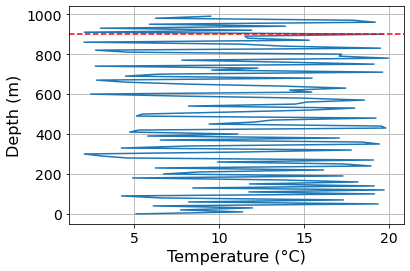

In [42]:
fontsize=16

class OceanProfileGUI:
    def __init__(self, root, temperature_profiles):
        self.root = root
        self.root.title("Mixed Layer Depth Analysis Software")

        self.temperature_profiles = temperature_profiles
        self.num_profiles = len(temperature_profiles)
        self.current_profile_index = 0  # Index of the currently displayed profile

        self.canvas = plt.figure(figsize=(6, 4))
        self.plot_area = self.canvas.add_subplot(111)
        self.plot_area.set_xlabel("Temperature (°C)", fontsize=fontsize)
        self.plot_area.set_ylabel("Depth (m)", fontsize=fontsize)
        # Set font size for tick labels
        self.plot_area.tick_params(axis='both', which='major', labelsize=14)

        depth, temperature = temperature_profiles[self.current_profile_index]
        self.plot_area.plot(temperature, depth)
        self.plot_area.grid(True)  # Enable grid lines
        self.canvas_widget = FigureCanvasTkAgg(self.canvas, master=root)
        self.canvas_widget.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)  # Fill window and expand to fit

        self.selected_depth = None
        self.recorded_depths = []  # List to store recorded depths

        # Create a side box to display profile index and depth
        self.side_box = tk.Text(root, height=10, width=20)
        self.side_box.pack(side=tk.RIGHT)

        # Connect event handlers
        self.canvas_widget.mpl_connect('motion_notify_event', self.on_hover_profile)
        self.canvas_widget.mpl_connect('button_press_event', self.on_click_profile)

        self.update_side_box()  # Update the side box with current profile index

        self.next_button = tk.Button(root, text="Next", command=self.load_next_profile)
        self.next_button.pack()

        # Store the reference to the red dashed line
        self.red_line = None

    def load_next_profile(self):
        # Record the last clicked depth if available before moving to the next profile
        if self.selected_depth is not None:
            self.recorded_depths.append(self.selected_depth)

        # Load and plot the next profile if not all profiles have been displayed
        if self.current_profile_index < self.num_profiles - 1:
            self.current_profile_index += 1
            self.plot_area.clear()
            depth, temperature = self.temperature_profiles[self.current_profile_index]
            self.plot_area.plot(temperature, depth)
            self.plot_area.grid(True)  # Enable grid lines
            self.selected_depth = None  # Reset selected depth for the new profile

            # Reset reference to red dashed line
            self.red_line = None

            self.update_side_box()  # Update the side box with current profile index
            self.canvas_widget.draw()
        else:
            # Close the GUI if all profiles have been displayed
            self.root.quit()
            self.root.destroy()

    def on_hover_profile(self, event):
        # Display depth in side box as you hover over the profile
        if event.xdata is not None and event.ydata is not None:
            depth = event.ydata
            self.update_side_box(hover_depth=depth)  # Update the side box with current profile index and hover depth

            # Get the current plot size
            canvas_width, canvas_height = self.canvas_widget.get_tk_widget().winfo_width(), self.canvas_widget.get_tk_widget().winfo_height()

            # Calculate the position of the red dashed line based on the plot size
            x_left, x_right = self.plot_area.get_xlim()
            y_bottom, y_top = self.plot_area.get_ylim()
            x_data = (event.x - 70) / canvas_width * (x_right - x_left) + x_left  # Adjust x-coordinate for padding
            y_data = event.y / canvas_height * (y_top - y_bottom) + y_bottom

            # Draw red horizontal dashed line following cursor
            if self.red_line is not None:
                self.red_line.set_ydata(y_data)
            else:
                self.red_line = self.plot_area.axhline(y_data, color='r', linestyle='--')

            self.canvas_widget.draw()

    def on_click_profile(self, event):
        # Record depth when clicking on profile
        if event.xdata is not None and event.ydata is not None:
            self.selected_depth = event.ydata
            self.update_side_box()  # Update the side box with current profile index and MLD

    def update_side_box(self, hover_depth=None):
        # Update the side box with current profile index and depth
        self.side_box.delete(1.0, tk.END)  # Clear previous content
        self.side_box.insert(tk.END, f"Profile: {self.current_profile_index + 1}/{self.num_profiles}\n")
        if self.selected_depth is not None:
            self.side_box.insert(tk.END, f"MLD Depth: {self.selected_depth:.2f} m\n")
        if hover_depth is not None:
            self.side_box.insert(tk.END, f"Depth: {hover_depth:.2f} m\n")

if __name__ == "__main__":
    # Assuming temperature_profiles is the variable containing the loaded profiles

    # Create the GUI
    root = tk.Tk()
    gui = OceanProfileGUI(root, temperature_profiles)
    root.mainloop()

    # Output recorded depths
    print("MLD Recorded Depths:", gui.recorded_depths)